<a href="https://colab.research.google.com/github/l-longo/A_neural_network_ensemble_approach_for_GDP_forecasting/blob/main/lstm%2B1_forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **LSTM one quarter ahead prediction**

Import libraries:

In [1]:
import os
import random
from numpy.random import seed
import tensorflow as tf
import pandas as pd
from pandas import DataFrame
import numpy as np
from pandas import concat
from keras.models import Sequential
from keras.layers import GRU as LSTM
from keras.layers import Dense
from sklearn.preprocessing import MinMaxScaler
from numpy import concatenate
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from matplotlib import pyplot
import keras
from google.colab import files

In [2]:
os.environ['PYTHONHASHSEED']='34'
os.environ['CUDA_VISIBLE_DEVICE']=''
np.random.seed(100)
random.seed(30)
tf.random.set_seed(30)

In [3]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg


Import FRED dataset:

In [4]:
uploaded = files.upload()
df1 = pd.read_excel('monthly.xlsx',index_col=0)
df1 = df1[df1['date']<'2020-02-01']
gdp = pd.read_excel('gdp.xlsx',sheet_name='Sheet1',index_col=0)

Saving gdp.xlsx to gdp.xlsx
Saving monthly.xlsx to monthly.xlsx


In [5]:
variables = list(df1.drop(['date'], axis=1).columns)
df1 = df1.fillna(0)
dataset = df1.to_numpy()
df1 = pd.DataFrame(data=df1,columns=variables)
gdp_train = gdp[gdp.index<'2005-05-01']
gdp_test = gdp[gdp.index>'2005-04-01']
gdp_val = gdp_train[gdp_train.index>'1998-01-01']
max_horizon = 3
n_train_hours = 424 - max_horizon
lags = 1
values = df1.values
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

Rescale features:

In [6]:
values = df1.values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
n_features = np.size(variables)

Supervised learning:

In [7]:
reframed = series_to_supervised(scaled, lags, 3)
print(reframed.shape)

(598, 552)


Split into train and test sets:

In [8]:
values = reframed.values
train = values[:n_train_hours, :]
validation = values[(n_train_hours - 84):n_train_hours, :]
T=np.size(train[:,0])
Tv=np.size(validation[:,0])

Split into input and outputs:

In [9]:
n_obs = lags * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features*3]
validation_X, validation_y = validation[:, :n_obs], validation[:, -n_features*3]
train_y=np.array([train_y,train[:, -n_features*2]]).T
validation_y=np.array([validation_y,validation[:, -n_features*2]]).T
train_y=np.hstack((train_y,np.resize(train[:, -n_features],(T,1))))
validation_y=np.hstack((validation_y,np.resize(validation[:, -n_features],(Tv,1))))

Reshape input to be 3D [samples, timesteps, features]:


In [10]:
train_X = train_X.reshape((train_X.shape[0], lags, n_features))
validation_X = validation_X.reshape((validation_X.shape[0], lags, n_features))
test = values[n_train_hours:, :]
Ts=np.size(test[:,0])
test_X, test_y = test[:, :n_obs], test[:, -n_features*3]
test_y=np.array([test_y,test[:, -n_features*2]]).T
test_y=np.hstack((test_y,np.resize(test[:, -n_features],(Ts,1))))
test_X = test_X.reshape((test_X.shape[0], lags, n_features))

t, node = 3, 7

Define the LSTM with Keras:

In [11]:
model = Sequential()
model.add(LSTM(5*(1+t)+(10*node+10)-5, activation='selu', input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(10*node + 10))
model.add(Dense(3)) 


Train the weights of the LSTM:

In [12]:
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
model.fit(train_X, train_y, epochs=150, batch_size=32, validation_data=(validation_X, validation_y),
      verbose=0, shuffle=False)

Invert scaling for forecast:


In [13]:
yhat = model.predict(test_X)
yhat1=np.array([yhat[:,0]]).T
yhat2=np.array([yhat[:,1]]).T
yhat3=np.array([yhat[:,2]]).T
test_X = test_X.reshape((test_X.shape[0], lags*n_features))

inv_yhat1 = concatenate((yhat1, test_X[:, -(n_features-1):]), axis=1)
inv_yhat1 = scaler.inverse_transform(inv_yhat1)
inv_yhat1 = inv_yhat1[:,0]
inv_yhat2 = concatenate((yhat2, test_X[:, -(n_features-1):]), axis=1)
inv_yhat2 = scaler.inverse_transform(inv_yhat2)
inv_yhat2 = inv_yhat2[:,0]
inv_yhat3 = concatenate((yhat3, test_X[:, -(n_features-1):]), axis=1)
inv_yhat3 = scaler.inverse_transform(inv_yhat3)
inv_yhat3 = inv_yhat3[:,0]
inv_yhat3 = concatenate((yhat3, test_X[:, -(n_features-1):]), axis=1)
inv_yhat3 = scaler.inverse_transform(inv_yhat3)
inv_yhat3 = inv_yhat3[:,0]

In [14]:
cc = gdp_test.to_numpy()
cc1 = np.hstack((cc,np.array([inv_yhat3]).T))
test = pd.DataFrame(data=cc1, columns=['actual', 'pred'])
test = test.dropna()
test_final = test

In [15]:
test_final

,actual,pred
2,3.6,2.853614
5,2.6,3.176595
8,5.4,2.978689
11,0.9,2.660404
14,0.6,1.787269
17,3.5,1.240432
20,0.9,1.253365
23,2.3,1.194096
26,2.2,1.123288
29,2.5,0.618469


<Figure size 432x288 with 0 Axes>

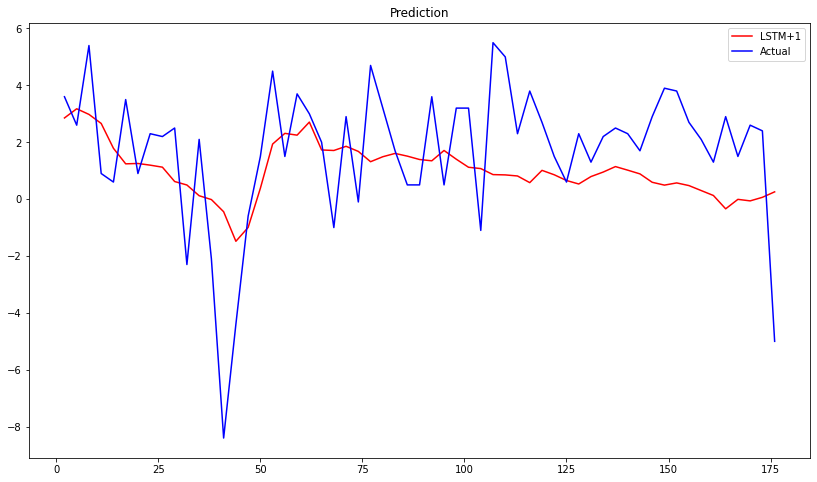

In [16]:
fig = plt.figure()
plt.figure(figsize=(14, 8))
plt.plot(test['pred'],'r', label='LSTM+1')
plt.plot(test['actual'],'blue', label='Actual')
plt.legend()
plt.title('Prediction')
plt.show()

Generate forecast with extending-window every two years of data:

In [17]:
ext_forecast = np.zeros((test_final.shape))
ext_forecast[:8,:] = test_final.iloc[:8,:]

In [18]:
for i in range(6):

    df1 = pd.read_excel('monthly.xlsx',index_col=0)
    df1 = df1[df1['date']<'2020-02-01']
    gdp=pd.read_excel('gdp.xlsx',sheet_name='Sheet1',index_col=0)
    
    
    
    variables = list(df1.drop(['date'], axis=1).columns)
    
    max_horizon=3
    n_train_hours = 424 + 6*4*(i+1) - max_horizon
    df1=df1.fillna(0)
    dataset=df1.to_numpy()
    df1=pd.DataFrame(data=df1,columns=variables)
    gdp_train=gdp.iloc[:n_train_hours + max_horizon,:]
    gdp_test=gdp.iloc[n_train_hours + max_horizon:,:]
    gdp_val=gdp_train.iloc[n_train_hours + max_horizon - 84]
    lags = 1
    
    values = df1.values
    values = values.astype('float32')
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)
    
    n_hours = lags
    n_features = np.size(variables)
    reframed = series_to_supervised(scaled, n_hours, 3)
    print(reframed.shape)
    values = reframed.values
    train = values[:n_train_hours, :]
    validation = values[(n_train_hours - 84):n_train_hours, :]
    T=np.size(train[:,0])
    Tv=np.size(validation[:,0])
    n_obs = n_hours * n_features
    train_X, train_y = train[:, :n_obs], train[:, -n_features*3]
    validation_X, validation_y = validation[:, :n_obs], validation[:, -n_features*3]
    train_y=np.array([train_y,train[:, -n_features*2]]).T
    validation_y=np.array([validation_y,validation[:, -n_features*2]]).T
    train_y=np.hstack((train_y,np.resize(train[:, -n_features],(T,1))))
    validation_y=np.hstack((validation_y,np.resize(validation[:, -n_features],(Tv,1))))
    train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
    validation_X = validation_X.reshape((validation_X.shape[0], n_hours, n_features))
    
    
    
    test = values[n_train_hours:, :]
    Ts=np.size(test[:,0])
    test_X, test_y = test[:, :n_obs], test[:, -n_features*3]
    test_y=np.array([test_y,test[:, -n_features*2]]).T
    test_y=np.hstack((test_y,np.resize(test[:, -n_features],(Ts,1))))
    test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
    
    t, node = 3, 7
    if i == 0:
        os.environ['PYTHONHASHSEED']='34'
        os.environ['CUDA_VISIBLE_DEVICE']=''
        random.seed(30)
        seed(30)
        tf.random.set_seed(30)
        model = Sequential()
        model.add(LSTM(160, activation='selu', input_shape=(train_X.shape[1], train_X.shape[2])))
        model.add(Dense(100))
        model.add(Dense(3)) 
        
        model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
        history = model.fit(train_X, train_y, epochs=50, batch_size=42, validation_data=(validation_X, validation_y),
          verbose=0, shuffle=False)
        
    elif i == 1:
        os.environ['PYTHONHASHSEED']='34'
        os.environ['CUDA_VISIBLE_DEVICE']=''
        random.seed(30)
        seed(30)
        tf.random.set_seed(30)
        
        
        model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
        history = model.fit(train_X, train_y, epochs=200, batch_size=32, validation_data=(validation_X, validation_y),
          verbose=0, shuffle=False)
        
    
    elif i==2:
        os.environ['PYTHONHASHSEED']='34'
        os.environ['CUDA_VISIBLE_DEVICE']=''
        random.seed(30)
        seed(30)
        tf.random.set_seed(30)
        
        
        model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
        history = model.fit(train_X, train_y, epochs=50, batch_size=32, validation_data=(validation_X, validation_y),
          verbose=0, shuffle=False)
        
    elif i==3:
        os.environ['PYTHONHASHSEED']='34'
        os.environ['CUDA_VISIBLE_DEVICE']=''
        random.seed(30)
        seed(30)
        tf.random.set_seed(30)
        
        
        model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
        history = model.fit(train_X, train_y, epochs=200, batch_size=32, validation_data=(validation_X, validation_y),
          verbose=0, shuffle=False)
        
    elif i==4:
        os.environ['PYTHONHASHSEED']='34'
        os.environ['CUDA_VISIBLE_DEVICE']=''
        random.seed(30)
        seed(30)
        tf.random.set_seed(30)
        model = Sequential()
        model.add(LSTM(300, activation='selu', input_shape=(train_X.shape[1], train_X.shape[2])))
        model.add(Dense(100))
        model.add(Dense(3)) 
        
        model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
        history = model.fit(train_X, train_y, epochs=140, batch_size=32, validation_data=(validation_X, validation_y),
          verbose=0, shuffle=False)
        
    else:
        os.environ['PYTHONHASHSEED']='34'
        os.environ['CUDA_VISIBLE_DEVICE']=''
        random.seed(30)
        seed(30)
        tf.random.set_seed(30)
        model = Sequential()
        model.add(LSTM(150, activation='selu', input_shape=(train_X.shape[1], train_X.shape[2])))
        model.add(Dense(50))
        model.add(Dense(3)) 
        
        model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
        history = model.fit(train_X, train_y, epochs=200, batch_size=32, validation_data=(validation_X, validation_y),
          verbose=0, shuffle=False)
        
    
    
    
    yhat = model.predict(test_X)
    yhat1=np.array([yhat[:,0]]).T
    yhat2=np.array([yhat[:,1]]).T
    yhat3=np.array([yhat[:,2]]).T
    test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))
    # invert scaling for forecast
    inv_yhat1 = concatenate((yhat1, test_X[:, -(n_features-1):]), axis=1)
    inv_yhat1 = scaler.inverse_transform(inv_yhat1)
    inv_yhat1 = inv_yhat1[:,0]
    inv_yhat2 = concatenate((yhat2, test_X[:, -(n_features-1):]), axis=1)
    inv_yhat2 = scaler.inverse_transform(inv_yhat2)
    inv_yhat2 = inv_yhat2[:,0]
    inv_yhat3 = concatenate((yhat3, test_X[:, -(n_features-1):]), axis=1)
    inv_yhat3 = scaler.inverse_transform(inv_yhat3)
    inv_yhat3 = inv_yhat3[:,0]
    inv_yhat3 = concatenate((yhat3, test_X[:, -(n_features-1):]), axis=1)
    inv_yhat3 = scaler.inverse_transform(inv_yhat3)
    inv_yhat3 = inv_yhat3[:,0]
    
    
    
    cc = gdp_test.to_numpy()
    cc1 = np.hstack((cc,np.array([inv_yhat3]).T))
    test1 = pd.DataFrame(data=cc1, columns=['actual', 'pred'])
    test1 = test1.dropna()
   

    ext_forecast[8*(i+1):,:] = test1




(598, 552)
(598, 552)
(598, 552)
(598, 552)
(598, 552)
(598, 552)


In [19]:
final_forecast = pd.DataFrame(ext_forecast)
final_forecast.index = gdp[gdp.index>'2005-04-01'].dropna().index

No handles with labels found to put in legend.


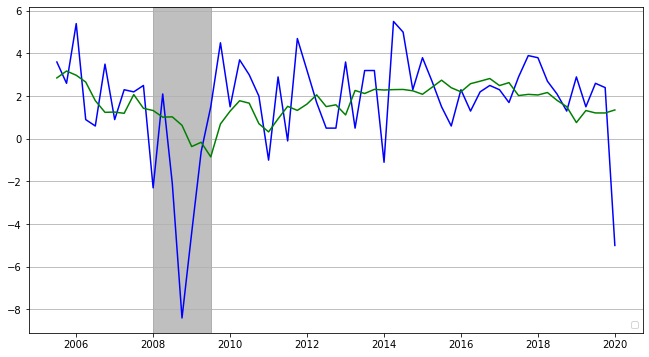

In [20]:
date = final_forecast.index
fig, ax = plt.subplots(figsize = (11, 6))
ax.plot(final_forecast.iloc[:,0], 'b')
ax.plot(final_forecast.iloc[:,1], 'g')
ax.yaxis.grid(True) # only horizontal grid
ax.legend(fontsize = 9, loc = 'lower right')
ax.axvspan(date[10],date[16],color = 'gray', alpha = .5, zorder = -1)
plt.show()